In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Search is started.
0- time: 0.00, count_rollouts: 1, reward: 0.0, node: PEPTIDE1{[ac].C.H.[dW].L.[Abu].[Nle].R.W.D.K.Y.[am]}$$$$
1- time: 0.19, count_rollouts: 2, reward: 0.0, node: PEPTIDE1{[dR].P.K.[dP].Q.[dQ].[dF].F.G.L.M.[am]}$$$$
2- time: 0.23, count_rollouts: 3, reward: 0.0, node: PEPTIDE1{[ac].F.Q.S.K.K.N.V.F.V.F.G.Y.Y.F.Q.L.R.A.K.L.[am]}$$$$
3- time: 0.29, count_rollouts: 4, reward: 0.0, node: PEPTIDE1{R.P.[dK].[dP].[dQ].[dQ].F.F.G.[dL].M.[am]}$$$$
4- time: 0.34, count_rollouts: 5, reward: 0.0, node: PEPTIDE1{Y.I.G.F.L.R.R.I.R.P.K.[am]}$$$$
5- time: 0.48, count_rollouts: 8, reward: 0.0, node: PEPTIDE1{A.R.Y.Y.S.A.L.R.H.Y.I.N.L.I.T.R.Q.R.Y.[am]}$$$$
6- time: 0.53, count_rollouts: 9, reward: 0.0, node: PEPTIDE1{T.P.R.E.R.R.R.K.K.R.G}$$$$
7- time: 0.67, count_rollouts: 12, reward: 0.0, node: PEPTIDE1{S.F.R.N.G.V.G.T.G.M.K.K.T.S.F.Q.R.A.K.S}$$$$
8- time: 0.82, count_rollouts: 14, reward: 0.0, node: PEPTIDE1{C.F.Q.W.Q.R.N.M.R.K.V.R}$$$$
9- time: 0.86, count_rollouts: 15, reward: 0.0

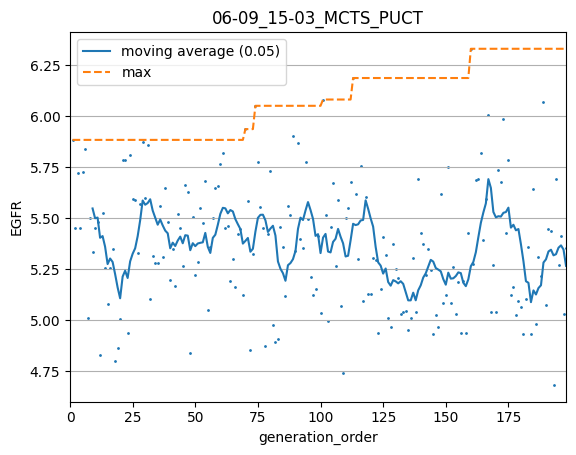

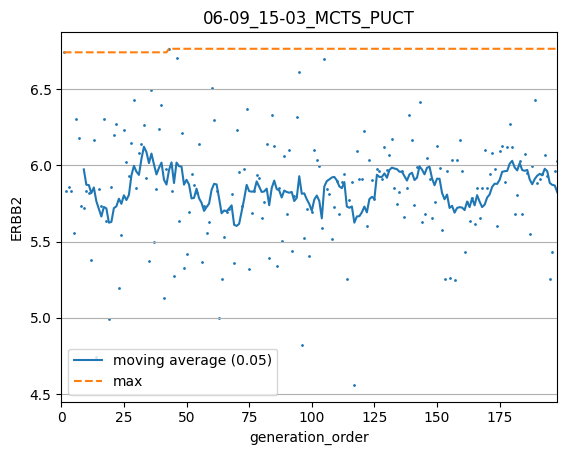

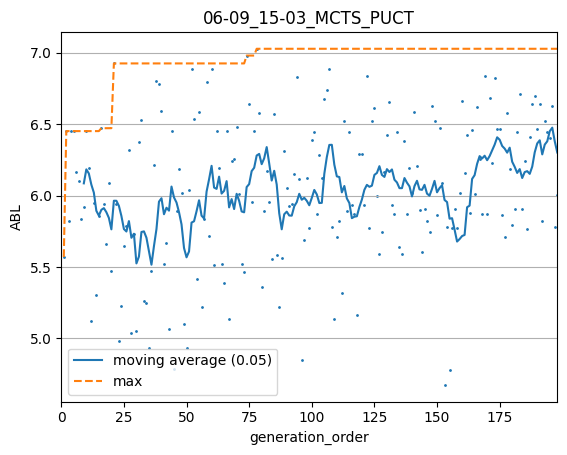

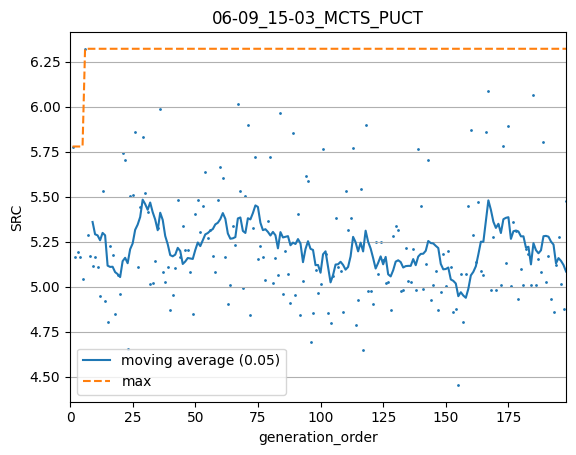

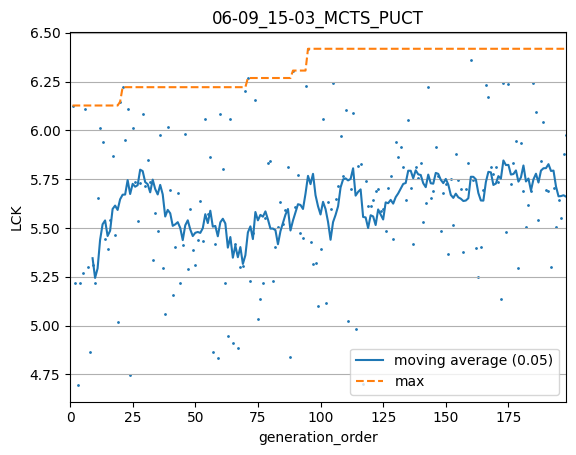

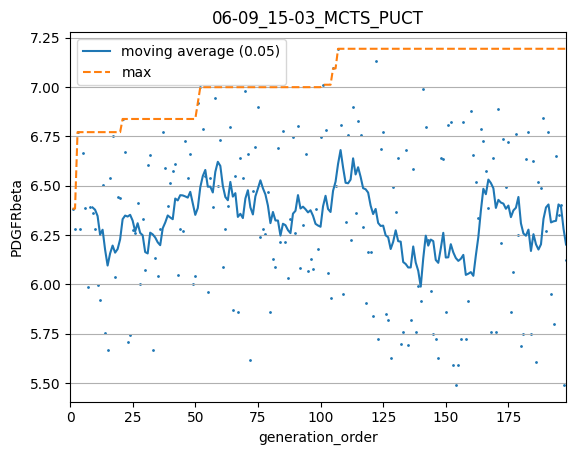

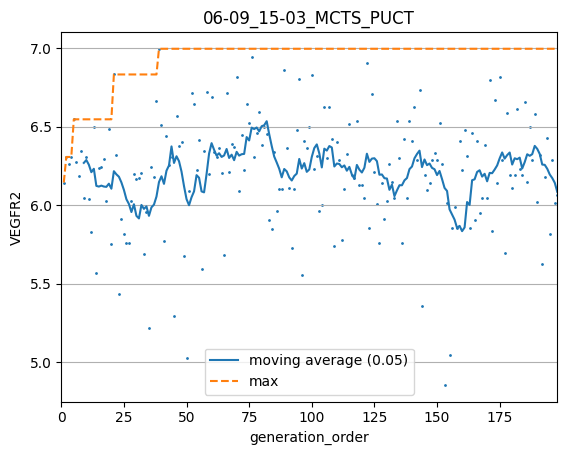

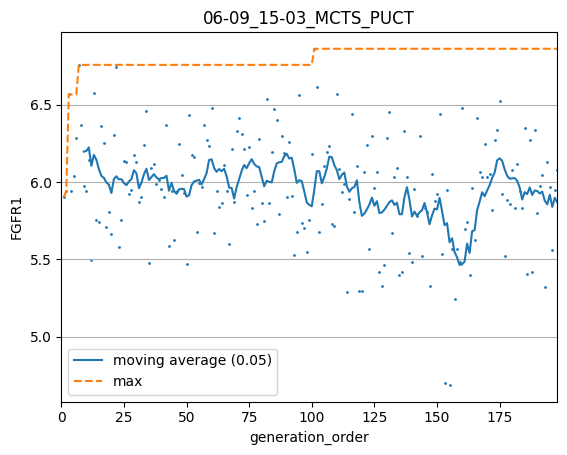

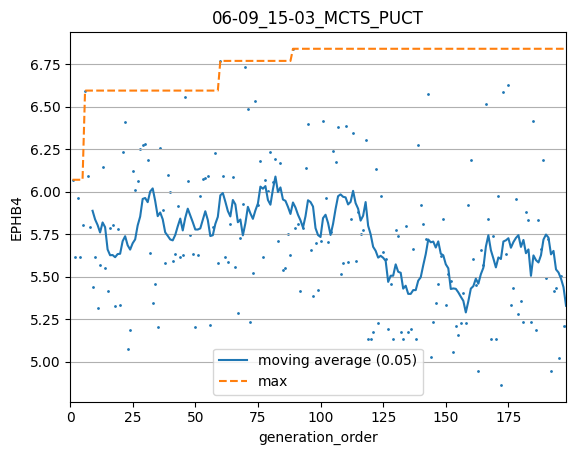

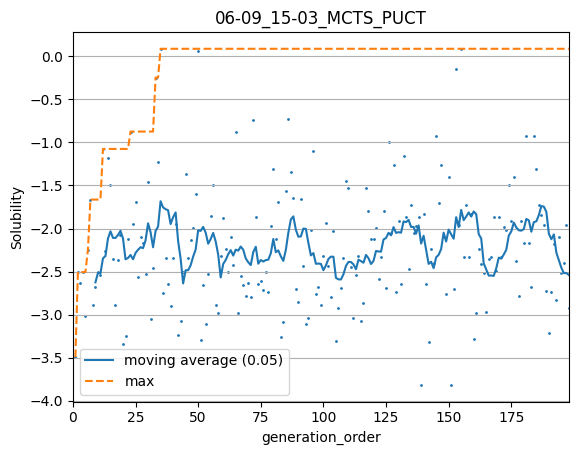

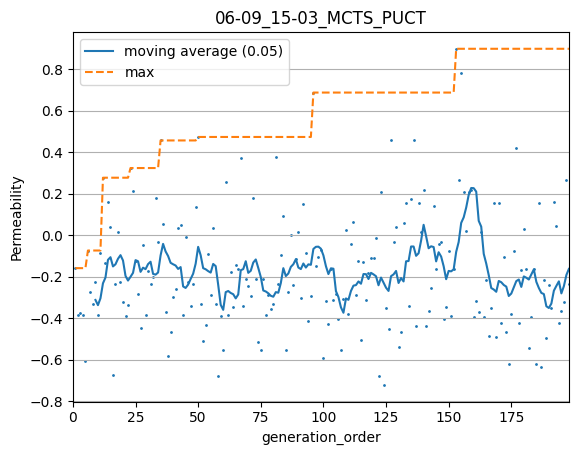

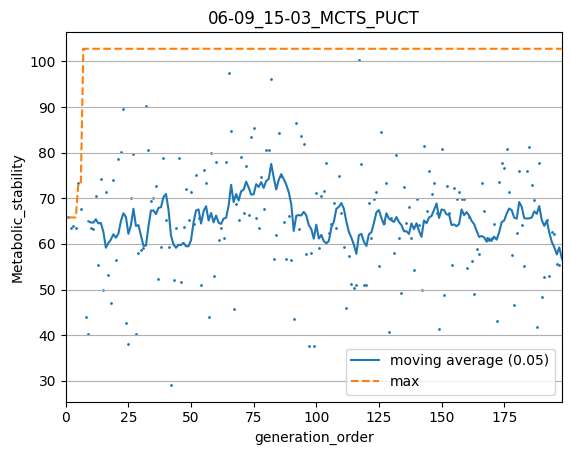

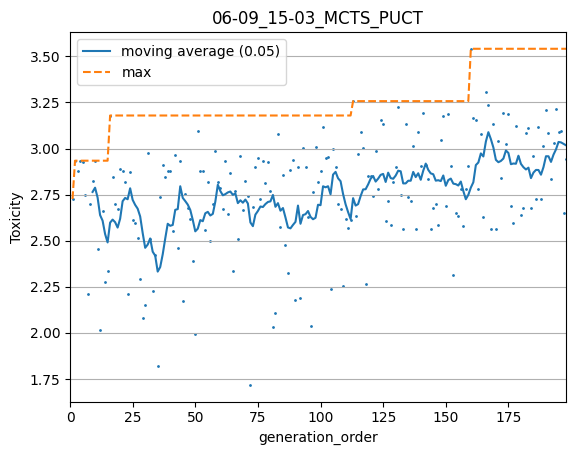

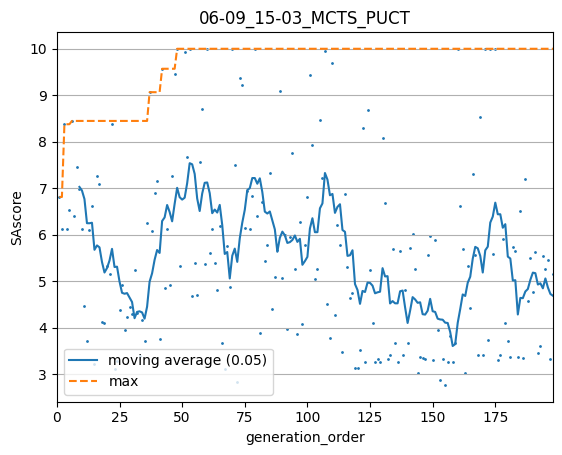

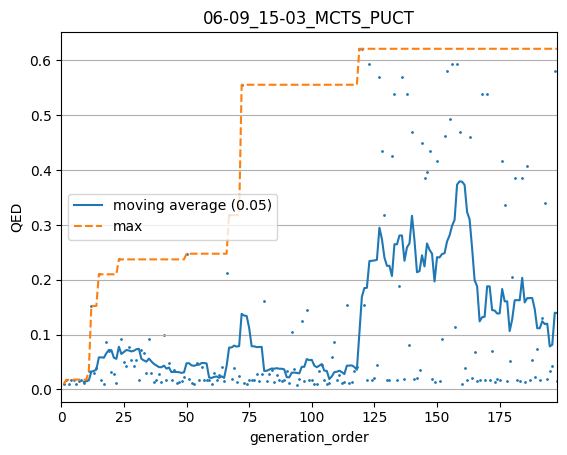

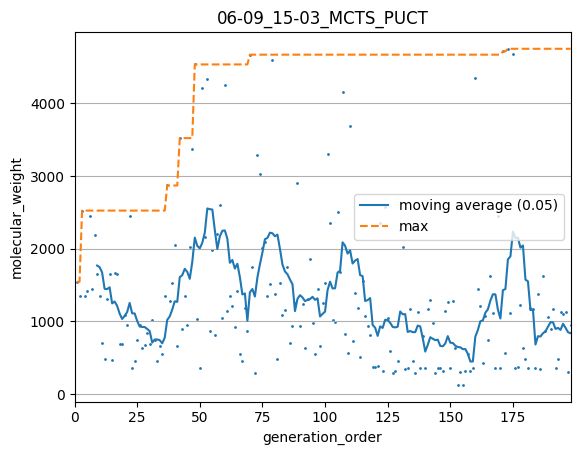

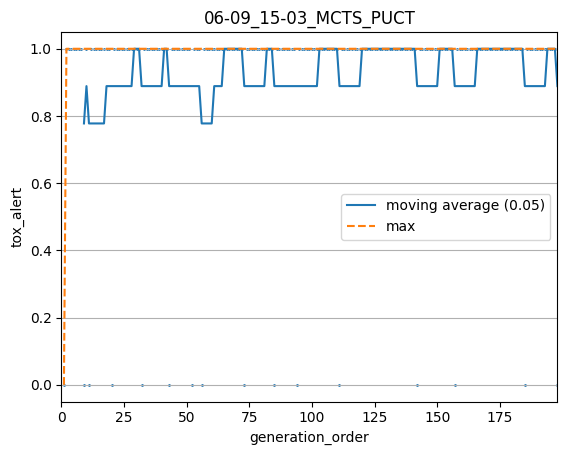

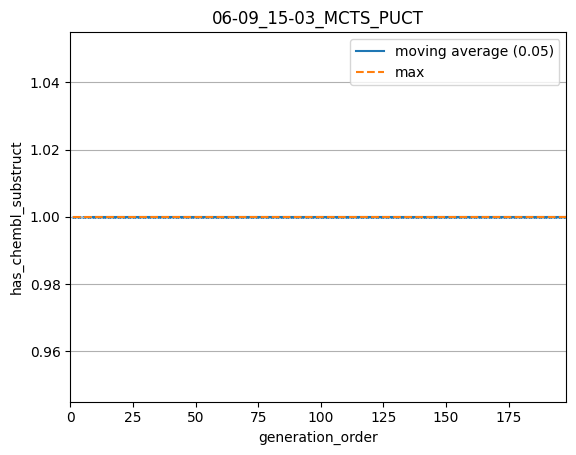

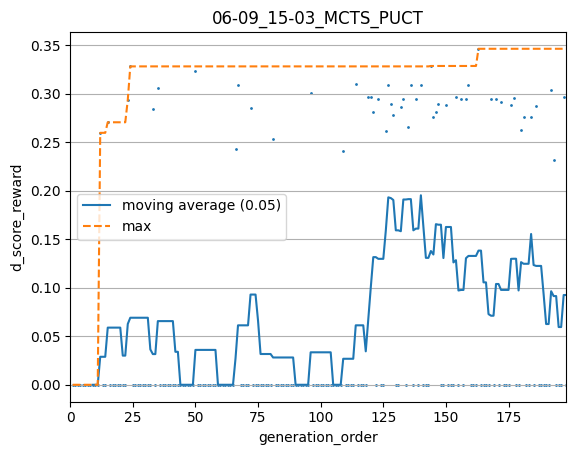

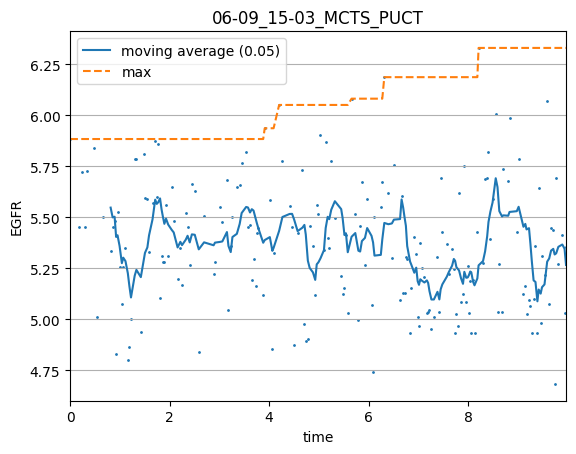

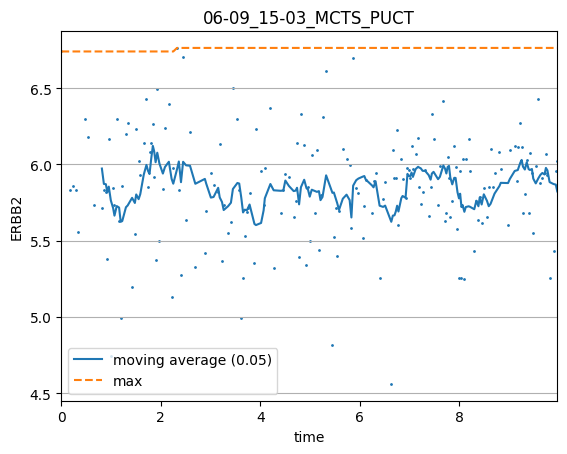

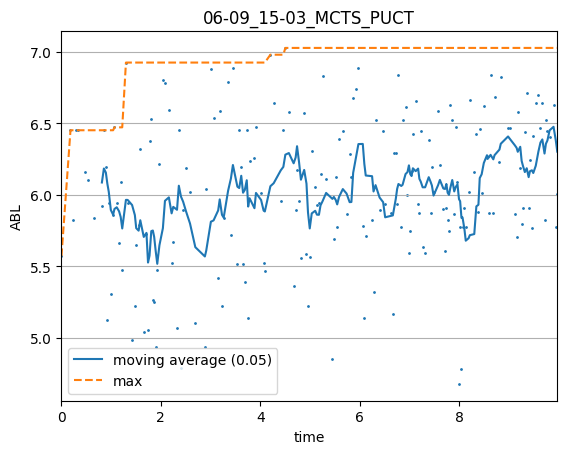

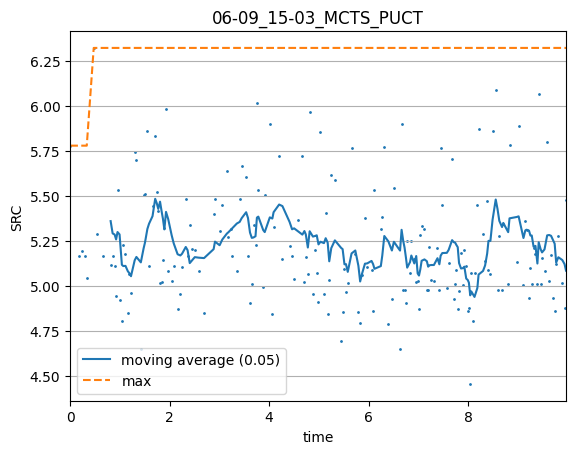

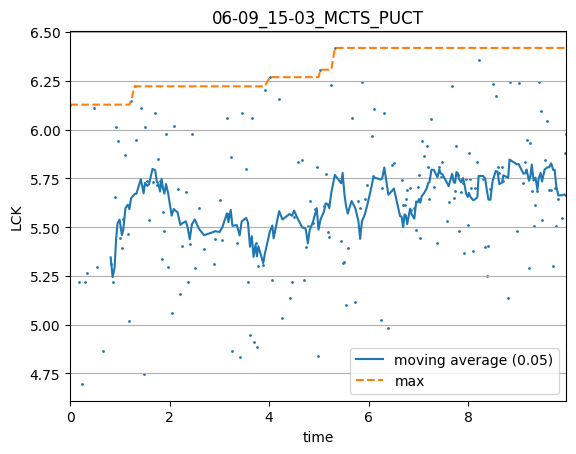

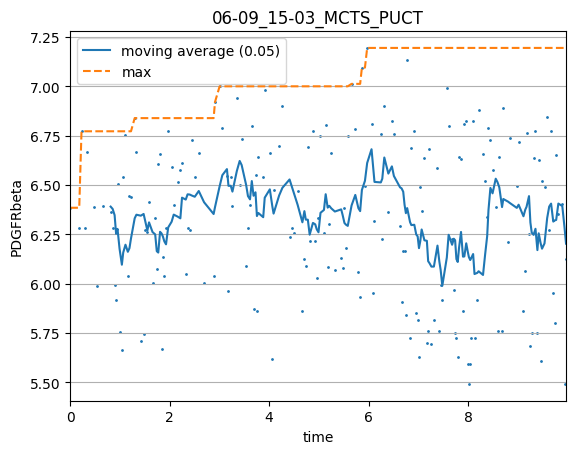

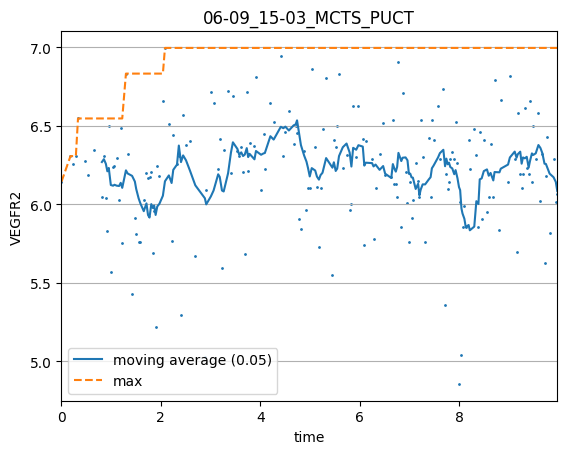

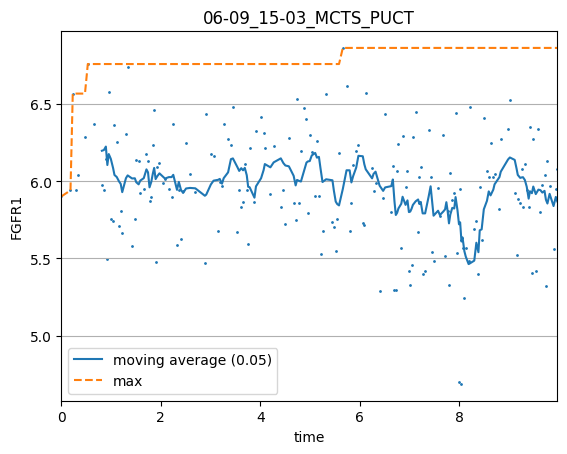

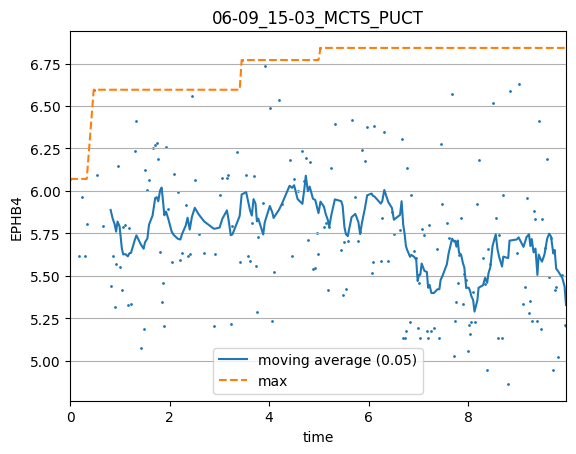

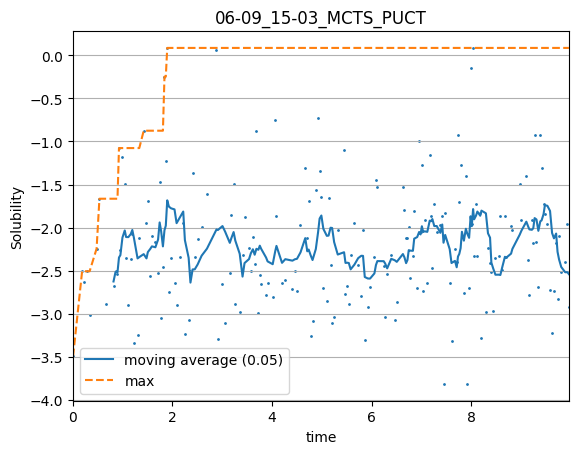

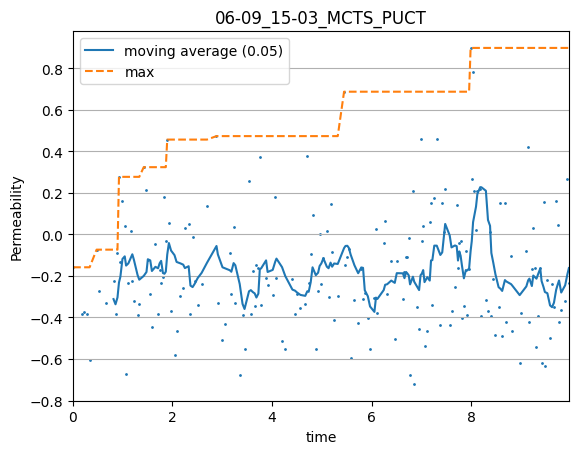

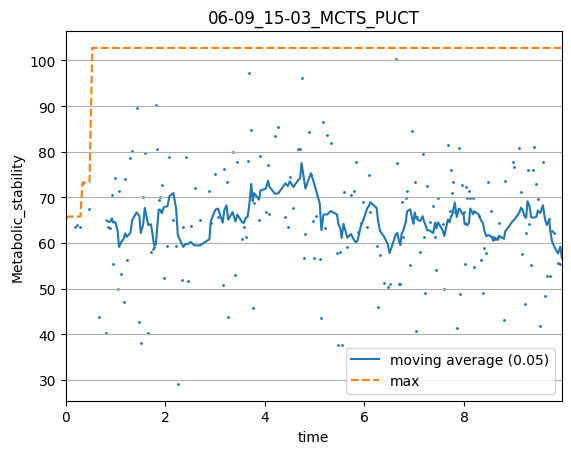

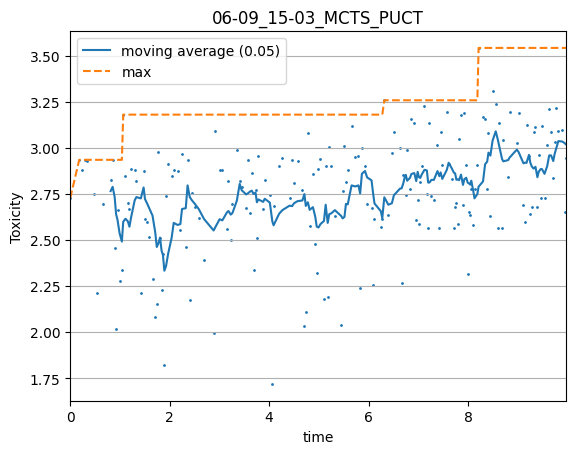

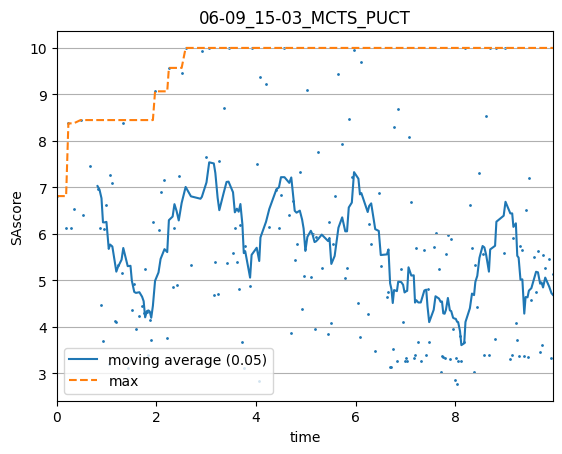

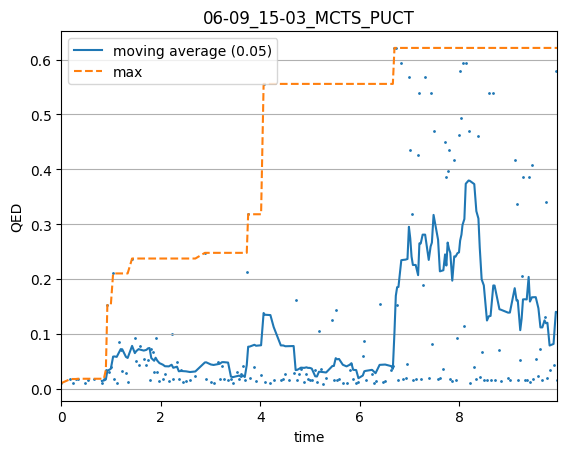

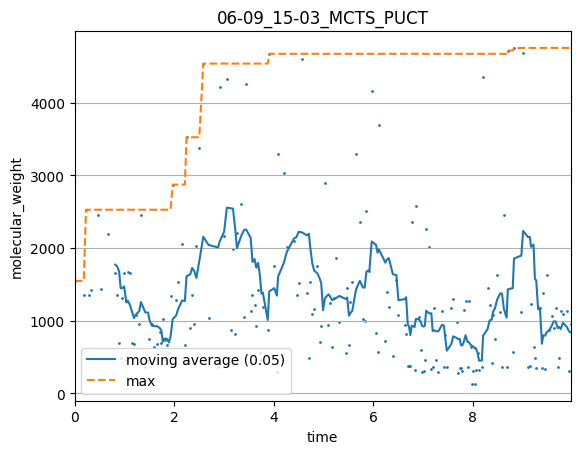

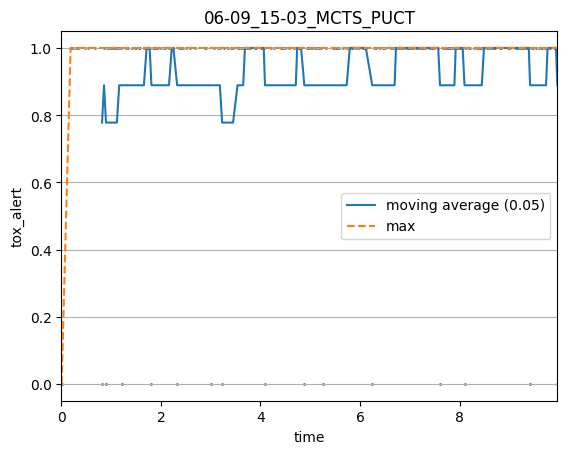

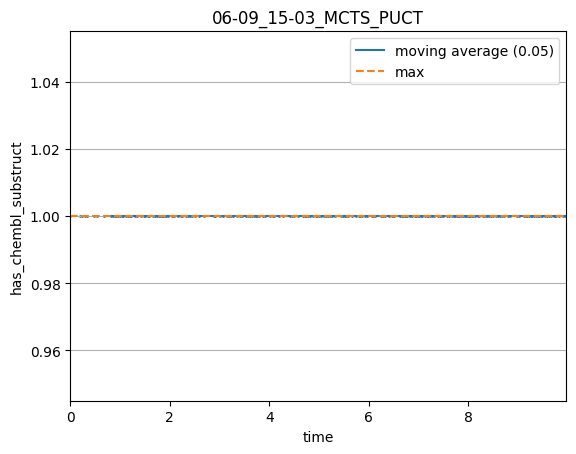

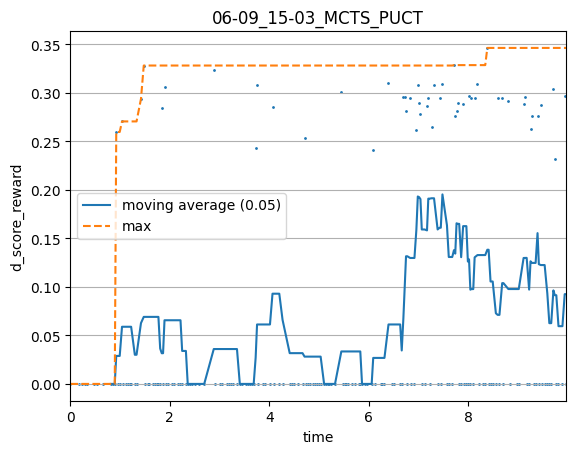

In [3]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)